# Анализ фильмов IMDb

В качестве проектной работы, я указывал, что хотел бы проанализировать зависимость итоговой оценки фильма от его жанра.

Всегда хотелось проверить, что в среднем, фильмы, которые людьми воспринимаются более серьезно, оцениваются высоко.
То есть Драмы, Детективы, Научная фантастика имеют в среднем более высокую оценку чем фильмы жанров вроде Комендия, Боевик, Хоррор.

Также, используя уже известные статистические методы, получим и другую интересную информацию. Например, попробуем предсказывать рейтинг фильма с помощью линейной регрессии. Посмотрим насколько важную роль в оценке будет играть жанр кино.

Для этого используем [датасет](https://data.world/data-society/imdb-5000-movie-dataset), содержащий следующие признаки:

* `movie_title` — название фильма.
* `title_year` — год выпуска (1916-2016).
* `content_rating` — возрастной рейтинг.
* `budget` — бюджет в долларах.
* `gross` — сборы в долларах.
* `imdb_score` — оценка IMDb.
* `genres` — жанры фильма.
* `color` — цветной или черно-белый
* `director_name` — имя режиссера фильма.
* `director_facebook_likes` — количество лайков на странице режиссера в Facebook.
* `actor_1_name` — главный актер.
* `actor_1_facebook_likes` — количество лайков на странице главного актера.
* `actor_2_name` — второй главный актер.
* `actor_2_facebook_likes` — количество лайков на странице второго главного актера.
* `actor_3_name` — третий главный актер.
* `actor_3_facebook_likes` — количество лайков на странице третьего главного актера.
* `cast_total_facebook_likes` — суммарное количетсов лайков актеров в Facebook.
* `movie_facebook_likes` — количество лайков на странице фильма в Facebook.
* `num_voted_users` — количество людей, поставивших оценку фильму на портале IMDb.
* `num_user_for_reviews` — количество людей, написавших отзыв к фильму на портале IMDb.
* `num_critic_for_reviews` — количество кинокритиков, оставивших отзыв о фильме.
* `plot_keywords` — ключевые слова.
* `movie_imdb_link` — ссылка на старницу фильма IMDb.
* `duration` — длительность фильма.
* `language` — язык фильма.
* `country` — страна производства.
* `facenumber_in_poster` — количество лиц актеров на постере к фильму.
* `aspect_ratio` — соотношение сторон.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

plt.style.use('seaborn-whitegrid')

df = pd.read_csv('movie_metadata.csv')
df.dropna(subset=['budget', 'gross'], inplace=True)

# Описательная статистика
#### Наиболее частые жанры
Cначала сформируем список жанров для дальнейшего анализа. Жанры, которые встречаются редко, добавлять не будем.

Если хотя бы у 300 фильмов присутствует жанр, то добавляем его в список жанров для анализа.

In [2]:
number_of_movies = {}
for genres in df.genres:
    for genre in genres.split('|'):
        if genre in number_of_movies:
            number_of_movies[genre] += 1
        else:
            number_of_movies[genre] = 0

genres = []
for genre in number_of_movies:
    if number_of_movies[genre] > 300:
        genres.append(genre)

print(*genres, sep='\n')

Action
Adventure
Fantasy
Sci-Fi
Thriller
Romance
Comedy
Family
Mystery
Drama
Crime
Horror


#### Визуализируем данные рейтинга IMDb

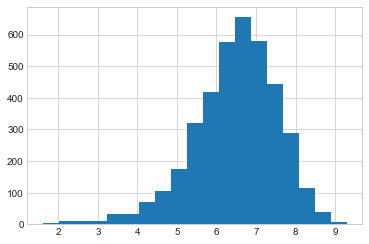

In [3]:
df['imdb_score'].hist(bins=19);

Распределение похоже на нормальное с небольшим сдвигом

#### Проверка на нормальность

Проверим на нормальность распределения рейтинга IMDb по наиболее частым жанрам

In [4]:
alpha = 0.05

genres_df = pd.DataFrame(columns=['mean', 'std', 'D', 'p-value', 'H0'])

for genre in genres:
    data = df[df['genres'].str.contains(genre)]
    
    a = data['imdb_score'].mean()
    sigma = data['imdb_score'].std()
    
    cdf = stats.norm(loc=a, scale=sigma).cdf
    kstest = stats.kstest(rvs=data['imdb_score'], cdf=cdf, alternative='greater')
    genres_df.loc[genre] = [a, sigma, *kstest, kstest[1] > alpha]
    
    
def true_green_color(var):
    color = 'Green' if var else 'White'
    return 'background-color: ' + color    
    
    
genres_df.sort_values(by=['mean'], ascending=False).style.applymap(true_green_color, subset=['H0'])

,mean,std,D,p-value,H0
Drama,6.78169,0.897529,0.0364883,0.00526312,False
Crime,6.54556,0.983356,0.0340248,0.18458,True
Mystery,6.46641,1.01835,0.0336348,0.404722,True
Adventure,6.45572,1.10945,0.0263946,0.324597,True
Romance,6.42905,0.965078,0.0383088,0.0719247,True
Thriller,6.3777,0.970412,0.0272922,0.182403,True
Sci-Fi,6.32395,1.15903,0.0320057,0.350803,True
Action,6.29062,1.03802,0.0327633,0.121927,True
Fantasy,6.28143,1.136,0.0210176,0.624616,True
Family,6.20993,1.16043,0.0283532,0.473781,True


В каждой строке мы исследовали только выборку фильмов, содержащую определенный жанр, который являеься индексом датафрейма.

Нам важен последний столбец. True означает, что можно принять гипотезу о том, что выборка нормальна.

Для 10 из 12 наиболее частых жанров при критическом значении равном 5% можно принять гипотезу о том, что распределение рейтинга IMDb нормальное по критерию Колмогорова-Смирнова.

Также заметим, что средняя оценка в зависимости от жанра довольно сильно отличаются.

Драма имеет заметно более высокую оценку, а комедия и хоррор заметно более низкую оценку.

#### Посмотрим на зависимость средней оценки в выборках определнного жанра
С помощью критерия Стьюдента для двух независимых выборок проверим гипотезу о равенстве среднего рейтинга IMDb для фильмов разных жанров.

В выборке X1 будут фильмы содержащие жанр 1, но не содержащие жанр 2.

В выборке X2 наоборот.

То есть фильмы в двух выборках не будут пересекаться.

In [5]:
alpha = 0.05
genres = ['Drama', 'Horror', 'Comedy', 'Romance', 'Mystery', 'Adventure', 'Action', 'Family', 'Fantasy']

genres_df = pd.DataFrame(columns=genres)

for genre1 in genres:
    a = []
    for genre2 in genres:
        if genre1 == genre2:
            a.append(True)
            continue
        X1 = df[df['genres'].str.contains(genre1) & ~df['genres'].str.contains(genre2)]['imdb_score']
        X2 = df[~df['genres'].str.contains(genre1) & df['genres'].str.contains(genre2)]['imdb_score']
        n1, n2 = len(X1), len(X2)
        
        T = (X1.mean() - X2.mean()) / np.sqrt(np.var(X1) / n1 + np.var(X2) / n2)
        t = stats.t.ppf(1 - alpha / 2, n1 + n2 - 2)
        
        a.append(-t < T < t)
    genres_df.loc[genre1] = a
    
genres_df.style.applymap(true_green_color)

,Drama,Horror,Comedy,Romance,Mystery,Adventure,Action,Family,Fantasy
Drama,True,False,False,False,False,False,False,False,False
Horror,False,True,False,False,False,False,False,False,False
Comedy,False,False,True,False,False,False,False,False,False
Romance,False,False,False,True,True,True,False,False,False
Mystery,False,False,False,True,True,True,False,False,False
Adventure,False,False,False,True,True,True,False,False,False
Action,False,False,False,False,False,False,True,True,True
Family,False,False,False,False,False,False,True,True,True
Fantasy,False,False,False,False,False,False,True,True,True


True в таблице означает, что мы принимаем гипотезу о том, что средняя оценка двух жанров равна.

Видим, что 6 жанров разбились на 2 группы:
* `Romance, Mystery, Adventure`
* `Action, Family, Fantasy`

А также, что особняком стоят жанры `Drama, Horror, Comedy`

Можно сделать вывод, что драмам в среднем всегда ставят оценки выше, чем другим фильмам, а хоррорам ниже, чем любым другим жанрам. Далее после хоррора идут комедии с низким рейтингом. Это я и хотел показать.

# Предиктивная аналитика

Теперь попробуем предсказывать рейтинг фильма с помощью линейной регрессии.

В выборку чуть позже будут добавлены новые признаки на основе популярных жанров.

Посмотрим насколько жанры в модели линейной регрессии влияют на оценку фильма.

Для начала избавимся от сильно коррелирующих пар признаков, заменяя их одним признаком.

#### Посмотрим на матрицу корреляций

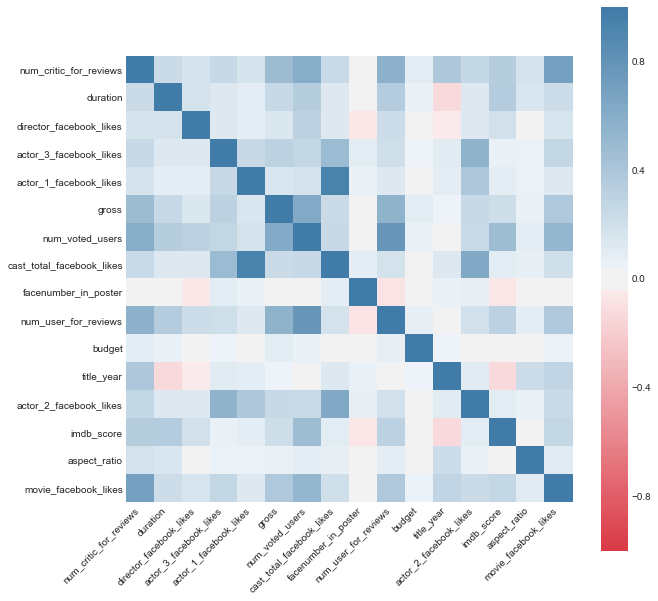

In [6]:
def heatmap(df):
    corr = df.corr()

    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(10, 240, n=200),
        square=True
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()
    
heatmap(df);

Видим, что наибольшая зависимость между суммарным числом лайков всему актерскому составу в Facebook и числом лайков только главному актеру. Также эти величины коррелируют с количествами лайков второму и третьему актеров. Эти четыре признака можно было бы преобразовать, например, в 2, число лайков главному актеру и сумму лайков оставшемуся составу актеров.

Так и сделаем.

In [7]:
df['cast_fb_likes_besides_1_actor'] = df['cast_total_facebook_likes'] - df['actor_1_facebook_likes']

Плюс количество людей написавших отзыв и поставивших оценку на сайте IMDb сильно коррелируют. Оставим один 

In [8]:
df.drop(columns=['cast_total_facebook_likes', 
                 'actor_1_facebook_likes', 
                 'actor_2_facebook_likes', 
                 'actor_3_facebook_likes',
                 'num_user_for_reviews'], inplace=True)

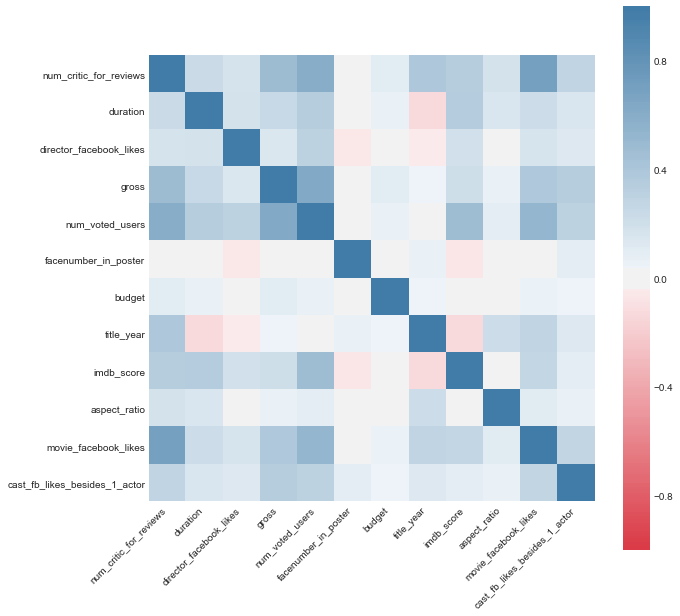

In [9]:
heatmap(df)

#### Теперь добавим признаки жанров в датасет

Создадим отдельные признаки под список самых частых жанров, который мы сформировали ранее:

In [10]:
print(*genres, sep=', ')

Drama, Horror, Comedy, Romance, Mystery, Adventure, Action, Family, Fantasy


In [11]:
for genre in genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

#### Предсказание оценки с помощью линейной регрессии

Разобьем наши данные на тренировочную и тестовую выборку.

In [12]:
X = df.select_dtypes(include=['float64', 'int64']).dropna()
y = X['imdb_score']
X.drop(columns='imdb_score', inplace=True)

In [13]:
scaler = StandardScaler()  # Для масштабирования значений признаков
X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), y, test_size=0.25)

In [14]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

check_test = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred.flatten(),
})


check_test.head(10)

,y_test,y_pred
2928,6.5,6.559957
475,5.1,6.149046
933,6.7,6.340336
758,5.3,5.653062
916,5.1,5.694138
2120,6.1,5.486790
4817,4.7,6.416179
1820,6.0,6.288622
3584,8.1,7.821986
2584,7.0,7.191831


In [15]:
print('{:<3} = {:.3f}\n{:<3} = {:.3f}\n{:<3} = {:.3f}'.format(
    'MSE', mean_squared_error(check_test["y_pred"], check_test["y_test"]),
    'MAE', mean_absolute_error(check_test["y_pred"], check_test["y_test"]),
    'R2', r2_score(y_test, y_pred)))

MSE = 0.610
MAE = 0.589
R2  = 0.465


Коэффициент детерминации показывает, что модель достаточно плохая.
Значит стоит попробовать использовать другую модель для предсказания оценок, например, дерево принятия решений.

Посмотрим на веса признаков в нашей модели линейной регрессии

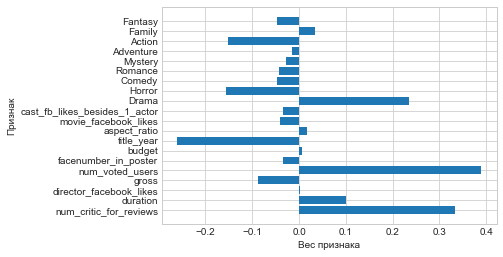

In [16]:
plt.barh(X.columns, lr.coef_.flatten())
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

Видно, что если фильм боевик, или хоррор, то это влияет на оценку в худшую сторону.

А если фильм драма, то влияет в лучшую сторону.

# Выводы

Жанр фильма действительно имеет значение при проставлении оценки пользователем на сайте IMDb.

Более "серьезные" фильмы, оцениваются в среднем выше.

Интересно, что в [top-250 IMDb](https://ru.wikipedia.org/wiki/250_%D0%BB%D1%83%D1%87%D1%88%D0%B8%D1%85_%D1%84%D0%B8%D0%BB%D1%8C%D0%BC%D0%BE%D0%B2_%D0%BF%D0%BE_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D0%B8_IMDb) более 80% фильмов содержат жанр драма. Жанр комедия около 15%. А фильмов ужасов всего 5.

В общем, выбирая очередную комедию или хоррор для просмотра, будьте более снисходительны к фильмам с низкой оценкой)